
The 7 classes of skin cancer lesions included in this dataset are:
Melanocytic nevi (nv)
Melanoma (mel)
Benign keratosis-like lesions (bkl)
Basal cell carcinoma (bcc) 
Actinic keratoses (akiec)
Vascular lesions (vas)
Dermatofibroma (df)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [10]:
skin_df = pd.read_csv('data/HAM10000/HAM10000_metadata.csv')

In [12]:
SIZE=32

le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))
 
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extr

C:\Users\Rasti fitness\AppData\Local\Temp\ipykernel_10112\1477313381.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


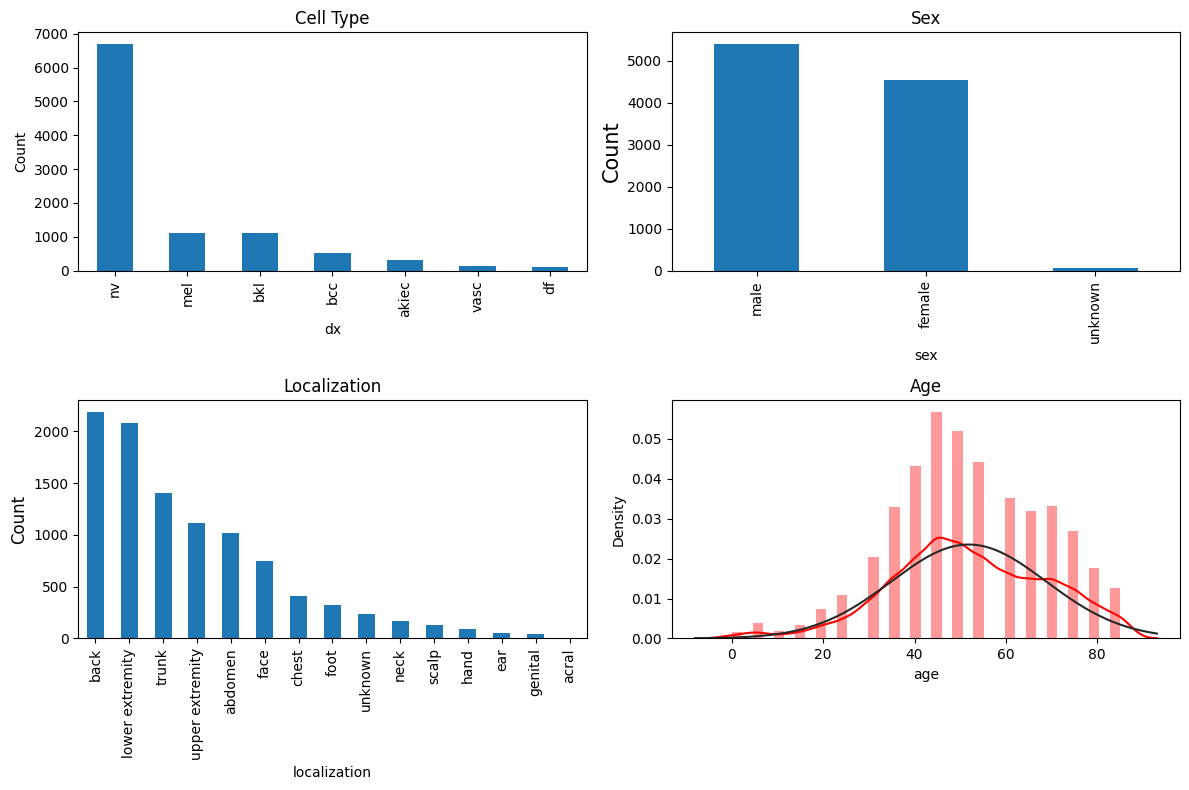

In [4]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()


In [1]:
from sklearn.utils import resample
print(skin_df['label'].value_counts())



df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)


In [6]:
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

#Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())

label
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: count, dtype: int64


In [7]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('data/HAM10000/', '*', '*.jpg'))}

In [8]:
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [9]:
print(skin_df_balanced)

        lesion_id      image_id     dx    dx_type   age     sex  \
9789  HAM_0003136  ISIC_0026645  akiec      histo  65.0    male   
9957  HAM_0006587  ISIC_0025780  akiec      histo  70.0    male   
9793  HAM_0005505  ISIC_0024450  akiec      histo  50.0    male   
9758  HAM_0003455  ISIC_0027896  akiec      histo  75.0    male   
9875  HAM_0005459  ISIC_0029268  akiec      histo  85.0    male   
...           ...           ...    ...        ...   ...     ...   
2375  HAM_0005989  ISIC_0033123   vasc      histo  25.0  female   
2436  HAM_0004943  ISIC_0027790   vasc  consensus  50.0  female   
2453  HAM_0001038  ISIC_0024706   vasc  consensus  50.0    male   
2377  HAM_0007097  ISIC_0033762   vasc      histo  60.0    male   
2363  HAM_0003862  ISIC_0033031   vasc      histo  45.0    male   

         localization  label  \
9789             back      0   
9957             face      0   
9793  upper extremity      0   
9758             hand      0   
9875  upper extremity      0   
...

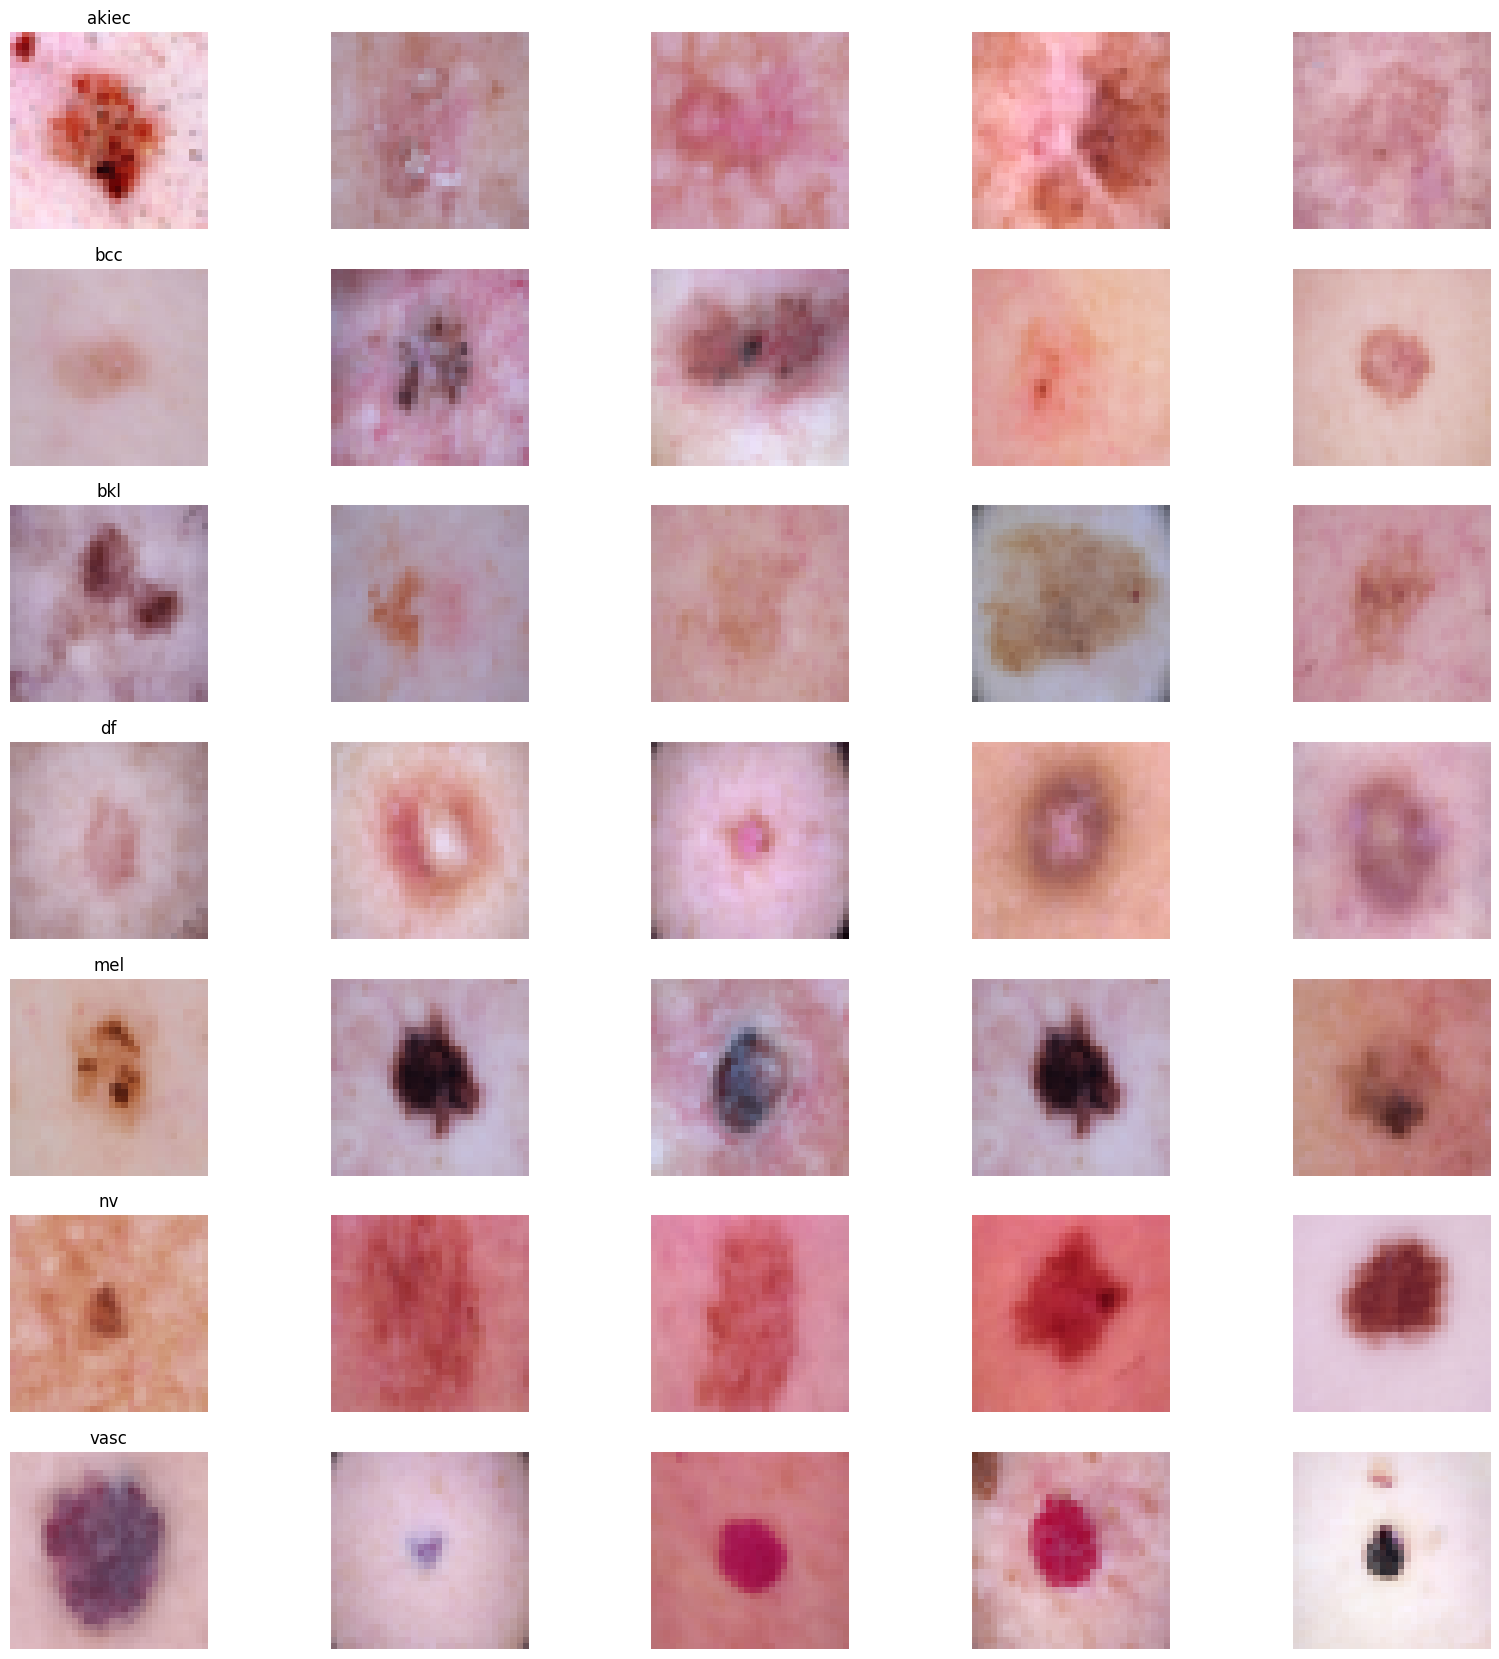

In [10]:
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [11]:
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)



In [12]:
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 256)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 128)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 128)        

In [13]:
batch_size = 16 
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])


Epoch 1/50


165/165 - 14s - loss: 1.8927 - acc: 0.1893 - val_loss: 1.8288 - val_acc: 0.2629 - 14s/epoch - 82ms/step
Epoch 2/50
165/165 - 11s - loss: 1.7514 - acc: 0.2693 - val_loss: 1.6495 - val_acc: 0.3909 - 11s/epoch - 64ms/step
Epoch 3/50
165/165 - 10s - loss: 1.5475 - acc: 0.3558 - val_loss: 1.4975 - val_acc: 0.4069 - 10s/epoch - 62ms/step
Epoch 4/50
165/165 - 11s - loss: 1.4883 - acc: 0.4072 - val_loss: 1.4447 - val_acc: 0.4331 - 11s/epoch - 66ms/step
Epoch 5/50
165/165 - 10s - loss: 1.4064 - acc: 0.4381 - val_loss: 1.5349 - val_acc: 0.3611 - 10s/epoch - 63ms/step
Epoch 6/50
165/165 - 10s - loss: 1.4219 - acc: 0.4389 - val_loss: 1.3685 - val_acc: 0.4206 - 10s/epoch - 62ms/step
Epoch 7/50
165/165 - 9s - loss: 1.3362 - acc: 0.4701 - val_loss: 1.3270 - val_acc: 0.4891 - 9s/epoch - 55ms/step
Epoch 8/50
165/165 - 9s - loss: 1.3110 - acc: 0.4891 - val_loss: 1.2852 - val_acc: 0.4857 - 9s/epoch - 55ms/step
Epoch 9/50
165/165 - 9s - loss: 1.2781 - acc: 0.4945 - val_loss: 1.2622 - val_acc:

In [14]:
model.save('model2.h5')

d:\Users\Rasti fitness\Desktop\Skin disease detection\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


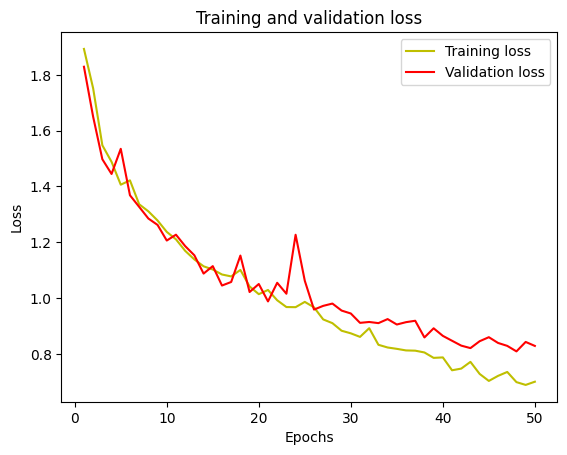

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

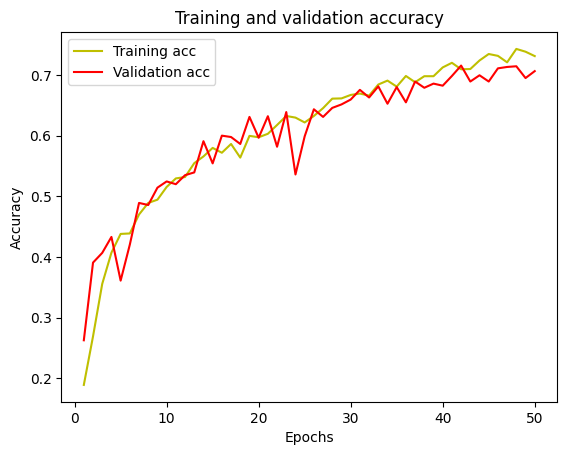

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

28/28 [==============================] - 1s 32ms/step


Text(45.722222222222214, 0.5, 'Fraction of incorrect predictions')

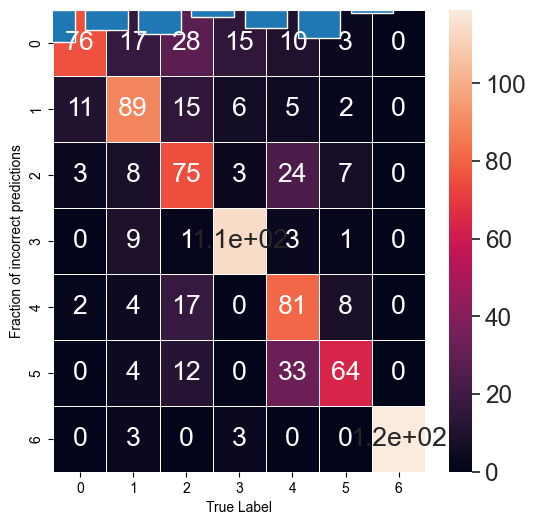

In [17]:
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

28/28 [==============================] - 1s 30ms/step
[3 4 4 3 0 4 3 3 2 0 3 5 6 1 1 1 1 2 6 5 0 3 0 3 2 2 1 0 3 6 6 3 4 1 6 6 0
 0 1 4 3 6 1 4 4 0 3 3 1 0 0 0 5 6 2 0 2 0 4 3 6 2 1 0 3 6 0 3 1 5 5 1 0 2
 1 4 6 5 6 3 6 6 6 6 5 5 2 5 0 0 4 6 1 5 6 5 0 2 3 1 0 4 2 2 0 0 6 6 1 0 0
 1 2 1 4 1 6 1 5 3 1 5 6 2 1 1 4 3 1 0 3 0 0 6 4 4 6 6 1 0 2 6 4 3 5 5 4 1
 2 0 0 4 4 1 5 2 0 3 0 3 5 5 0 5 2 1 2 4 4 3 3 1 0 2 3 6 1 5 1 6 6 2 0 0 2
 1 2 3 3 5 4 5 6 2 4 6 4 3 2 2 2 0 3 2 0 5 5 6 6 4 4 0 6 6 6 6 2 5 5 5 2 1
 0 1 5 3 6 2 3 3 4 3 1 6 1 3 2 3 0 1 1 0 1 5 3 3 4 1 6 3 2 6 3 0 1 3 5 2 1
 3 2 0 0 5 6 4 1 4 0 0 6 1 0 1 0 0 0 6 5 3 2 3 0 6 0 1 0 4 1 6 5 1 0 0 4 5
 5 1 0 3 0 0 1 6 2 1 5 3 1 5 6 6 1 5 1 6 4 1 2 0 5 6 2 4 2 0 0 3 1 1 2 1 6
 4 4 1 0 2 2 2 3 0 3 5 4 0 4 3 4 2 3 6 0 3 6 4 3 5 2 3 3 1 2 0 0 6 0 1 0 2
 4 6 2 3 0 4 0 2 5 3 2 0 1 3 4 0 0 4 4 0 0 0 4 4 0 4 5 4 0 0 2 2 0 3 2 3 4
 5 0 3 1 4 0 2 5 2 5 5 3 1 6 6 6 6 0 2 4 4 6 4 3 5 5 0 2 0 6 1 2 0 2 4 0 0
 1 2 5 3 6 6 0 3 5 1 4 6 6 2 4 4 1 0 6 5 5 0 5